In [1]:
# File: colab_goemotions_finetune.py


import kagglehub
import os
import json
import torch
from datasets import load_dataset, Dataset, DatasetDict
from transformers import (AutoModelForCausalLM, AutoTokenizer, AutoModelForSequenceClassification, 
                          Trainer, TrainingArguments)
from peft import get_peft_config, LoraConfig, PeftModel
import evaluate
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
from datasets import load_dataset

ds = load_dataset("google-research-datasets/go_emotions", "simplified")

In [ ]:
# Function to convert numeric labels to text
def convert_labels_to_one_int(example):
    #text_labels = [label_mapping[label] for label in example["labels"]]
    example["labels"] = example["labels"][0]
    return example

# Assuming `dataset` is your DatasetDict
dataset = DatasetDict({
    "train": ds["train"].map(convert_labels_to_one_int),
    "validation": ds["validation"].map(convert_labels_to_one_int),
    "test": ds["test"].map(convert_labels_to_one_int),
})



"""# Assuming you have already loaded the DatasetDict as `dataset`
dataset = DatasetDict({
    "train": dataset["test"],         # Swap test with train
    "validation": dataset["validation"],  # Keep validation as is
    "test": dataset["train"]          # Swap train with test
})"""

In [4]:
dataset["train"]["labels"][0:10]

[25, 0, 13, 15, 27, 15, 15, 15, 24, 25]

In [5]:
def preprocess_labels(example):
    example['labels'] = max(0, min(example['labels'], 27))  # Ensure labels are within range
    return example

dataset = dataset.map(preprocess_labels)

In [6]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Prepare the dataset for training
"""def preprocess_function(example, tokenizer, max_length=128):
    return tokenizer(example['text'], truncation=True, padding='max_length', max_length=max_length)"""
def preprocess_function(example, tokenizer, max_length=128):
    inputs = tokenizer(example['text'], truncation=True, padding='max_length', max_length=max_length)
    inputs['labels'] = torch.tensor(example['labels']).long()  # Convert to tensor
    return inputs


tokenizers = {
    "gpt2": AutoTokenizer.from_pretrained("gpt2"),
    "distilbert": AutoTokenizer.from_pretrained("distilbert-base-uncased"),
    "roberta": AutoTokenizer.from_pretrained("roberta-base"),
}

# Update model configuration for multi-label
from transformers import AutoConfig
# Models for fine-tuning
models = {
    "distilbert": {
        "path": "distilbert-base-uncased",
        "model": AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=28, cache_dir="./models"),
        "size": "750MB"
    }
}




Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
"""
# Prepare the dataset for training
def preprocess_function(example, tokenizer, max_length=128):
    return tokenizer(example['text'], truncation=True, padding='max_length', max_length=max_length)

# Prepare the tokenizers with padding token
tokenizers = {
    "gpt2": AutoTokenizer.from_pretrained("gpt2"),
    "distilbert": AutoTokenizer.from_pretrained("distilbert-base-uncased"),
    "roberta": AutoTokenizer.from_pretrained("roberta-base"),
}

# Ensure each tokenizer has a padding token
for model_name, tokenizer in tokenizers.items():
    if tokenizer.pad_token is None:
        if tokenizer.eos_token:
            tokenizer.pad_token = tokenizer.eos_token
        else:
            tokenizer.add_special_tokens({'pad_token': '[PAD]'})


# Models for fine-tuning
models = {
    "gpt2": {
        "path": "gpt2",
        "model": AutoModelForCausalLM.from_pretrained("gpt2", cache_dir="./models"),
        "size": "500MB"
    },
    "distilbert": {
        "path": "distilbert-base-uncased",
        "model": AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=27, cache_dir="./models"),
        "size": "750MB"
    },
    "roberta": {
        "path": "roberta-base",
        "model": AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=27, cache_dir="./models"),
        "size": "1GB"
    }
}
"""

'\n# Prepare the dataset for training\ndef preprocess_function(example, tokenizer, max_length=128):\n    return tokenizer(example[\'text\'], truncation=True, padding=\'max_length\', max_length=max_length)\n\n# Prepare the tokenizers with padding token\ntokenizers = {\n    "gpt2": AutoTokenizer.from_pretrained("gpt2"),\n    "distilbert": AutoTokenizer.from_pretrained("distilbert-base-uncased"),\n    "roberta": AutoTokenizer.from_pretrained("roberta-base"),\n}\n\n# Ensure each tokenizer has a padding token\nfor model_name, tokenizer in tokenizers.items():\n    if tokenizer.pad_token is None:\n        if tokenizer.eos_token:\n            tokenizer.pad_token = tokenizer.eos_token\n        else:\n            tokenizer.add_special_tokens({\'pad_token\': \'[PAD]\'})\n\n\n# Models for fine-tuning\nmodels = {\n    "gpt2": {\n        "path": "gpt2",\n        "model": AutoModelForCausalLM.from_pretrained("gpt2", cache_dir="./models"),\n        "size": "500MB"\n    },\n    "distilbert": {\n       

In [ ]:
def train_model(model_name, model, tokenizer, dataset, training_args, lora=False):
    if lora:
        print(f"Applying QLoRA to {model_name}...")
        # Dynamically set target modules based on the model type
        if model_name == "distilbert":
            target_modules = ["ffn.lin1", "ffn.lin2"]
        elif model_name == "roberta":
            target_modules = ["intermediate.dense", "output.dense"]
        elif model_name == "gpt2":
            target_modules = ["c_fc", "c_proj"]
        else:
            raise ValueError(f"LoRA target modules not defined for {model_name}")

        config = LoraConfig(
            r=16, lora_alpha=32, lora_dropout=0.1, target_modules=target_modules
        )
        model = PeftModel(model, config)

        # Freeze base model parameters
        for param in model.base_model.parameters():
            param.requires_grad = False
        print("Base model parameters frozen.")

        # Ensure LoRA parameters are trainable
        for name, param in model.named_parameters():
            if 'lora' in name:  # LoRA layers will have 'lora' in their names
                param.requires_grad = True
        print("LoRA parameters are trainable.")

    dataset = dataset.map(lambda x: preprocess_function(x, tokenizer), batched=True)
    dataset = dataset.remove_columns(['id'])  # Adjust as per GoEmotions structure
    from transformers import TrainerCallback
    import json
    from sklearn.metrics import accuracy_score
    import numpy as np

    # Define the compute_metrics function
    def compute_metrics(pred):
        logits, labels = pred
        predictions = np.argmax(logits, axis=-1)

        # Calculate accuracy
        accuracy = accuracy_score(labels, predictions)

        # Calculate the loss (use the loss function used during training)
        # Here we're using CrossEntropyLoss as an example
        loss_fn = torch.nn.CrossEntropyLoss()
        loss = loss_fn(torch.tensor(logits), torch.tensor(labels)).item()  # Calculate loss

        return {"accuracy": accuracy, "loss": loss}


    class LogMetricsCallback(TrainerCallback):
        def __init__(self, log_dir="./logs/log_history_real_train_data.json"):
            self.log_dir = log_dir
            self.logs = []

        def on_log(self, args, state, control, logs=None, **kwargs):
            if logs:
                log_entry = {
                    "epoch": logs.get("epoch"),
                    "train_loss": logs.get("loss"),
                    "learning_rate": logs.get("learning_rate"),
                    "grad_norm": logs.get("grad_norm", None),  # Gradient norm (if available)
                    "eval_loss": logs.get("eval_loss", None),  # Eval loss
                    "eval_accuracy": logs.get("eval_accuracy", None),  # Eval accuracy
                    "optimizer_state": logs.get("optimizer_state", None)  # Optimizer state (if available)
                }
                self.logs.append(log_entry)
                
                # Save logs to a file after each logging step
                with open(self.log_dir, "w") as f:
                    json.dump(self.logs, f, indent=4)


    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=dataset['train'],
        eval_dataset=dataset['validation'],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[LogMetricsCallback(log_dir="./logs/log_history.json")]  # Custom callback
    )
    trainer.train()
    return trainer


# Metrics computation
accuracy_metric = evaluate.load("accuracy")

"""def compute_metrics(pred):
    logits, labels = pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_metric.compute(predictions=predictions, references=labels)
    return {"accuracy": acc}"""



'def compute_metrics(pred):\n    logits, labels = pred\n    predictions = np.argmax(logits, axis=-1)\n    acc = accuracy_metric.compute(predictions=predictions, references=labels)\n    return {"accuracy": acc}'

In [9]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5427
    })
    validation: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 43410
    })
})

In [10]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Prepare the dataset for training
"""def preprocess_function(example, tokenizer, max_length=128):
    return tokenizer(example['text'], truncation=True, padding='max_length', max_length=max_length)"""
def preprocess_function(example, tokenizer, max_length=128):
    inputs = tokenizer(example['text'], truncation=True, padding='max_length', max_length=max_length)
    inputs['labels'] = torch.tensor(example['labels']).long()  # Convert to tensor
    return inputs


tokenizers = {
    "gpt2": AutoTokenizer.from_pretrained("gpt2"),
    "distilbert": AutoTokenizer.from_pretrained("distilbert-base-uncased"),
    "roberta": AutoTokenizer.from_pretrained("roberta-base"),
}

# Update model configuration for multi-label
from transformers import AutoConfig
# Models for fine-tuning
models = {
    "distilbert": {
        "path": "distilbert-base-uncased",
        "model": AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=28, cache_dir="./models"),
        "size": "750MB"
    }
}




Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import os

# Enable CUDA launch blocking for debugging
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"




# Training configurations
training_args = TrainingArguments(
    output_dir="./results_real_data",
    evaluation_strategy="batch",
    save_strategy="epoch",
    logging_dir="./logs",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=200,
    weight_decay=0.01,
    push_to_hub=False,
    logging_first_step=False,   # Make sure logs are being stored
)

# Train each model
results = {}
for model_name, model_info in models.items():
    print(f"Training {model_name} ({model_info['size']}) with standard fine-tuning...")
    results[model_name] = {}
    trainer = train_model(model_name, model_info["model"], tokenizers[model_name], dataset, training_args, lora=False)
    results[model_name]['standard'] = trainer.evaluate()
    
    """print(f"Training {model_name} ({model_info['size']}) with QLoRA...")
    trainer = train_model(model_name, model_info["model"], tokenizers[model_name], dataset, training_args, lora=True)
    results[model_name]['qlora'] = trainer.evaluate()"""

c:\Users\kpreube\miniconda3\envs\llm\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Training distilbert (750MB) with standard fine-tuning...


  0%|          | 0/68000 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 2.0258400440216064, 'eval_accuracy': 0.4719867305565794, 'eval_runtime': 5.5214, 'eval_samples_per_second': 982.723, 'eval_steps_per_second': 61.579, 'epoch': 1.0}
{'loss': 2.2568, 'grad_norm': 8.354150772094727, 'learning_rate': 1.985294117647059e-05, 'epoch': 1.47}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.707974910736084, 'eval_accuracy': 0.525617397714707, 'eval_runtime': 5.5466, 'eval_samples_per_second': 978.262, 'eval_steps_per_second': 61.299, 'epoch': 2.0}
{'loss': 1.5066, 'grad_norm': 15.943758964538574, 'learning_rate': 1.9705882352941178e-05, 'epoch': 2.94}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.6924551725387573, 'eval_accuracy': 0.53483228897899, 'eval_runtime': 5.5795, 'eval_samples_per_second': 972.494, 'eval_steps_per_second': 60.938, 'epoch': 3.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.739866852760315, 'eval_accuracy': 0.5379653520088463, 'eval_runtime': 5.6227, 'eval_samples_per_second': 965.015, 'eval_steps_per_second': 60.469, 'epoch': 4.0}
{'loss': 1.0082, 'grad_norm': 7.687646865844727, 'learning_rate': 1.9558823529411766e-05, 'epoch': 4.41}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.8269031047821045, 'eval_accuracy': 0.5291190563951346, 'eval_runtime': 5.3829, 'eval_samples_per_second': 1008.005, 'eval_steps_per_second': 63.163, 'epoch': 5.0}
{'loss': 0.6868, 'grad_norm': 11.710638999938965, 'learning_rate': 1.9411764705882355e-05, 'epoch': 5.88}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 1.9990277290344238, 'eval_accuracy': 0.501658680427571, 'eval_runtime': 5.3088, 'eval_samples_per_second': 1022.075, 'eval_steps_per_second': 64.045, 'epoch': 6.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 2.161651134490967, 'eval_accuracy': 0.5145595281975672, 'eval_runtime': 5.2667, 'eval_samples_per_second': 1030.245, 'eval_steps_per_second': 64.556, 'epoch': 7.0}
{'loss': 0.4226, 'grad_norm': 2.4027938842773438, 'learning_rate': 1.9264705882352943e-05, 'epoch': 7.35}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 2.2804954051971436, 'eval_accuracy': 0.48783634353114635, 'eval_runtime': 5.5421, 'eval_samples_per_second': 979.047, 'eval_steps_per_second': 61.348, 'epoch': 8.0}
{'loss': 0.2493, 'grad_norm': 25.546201705932617, 'learning_rate': 1.911764705882353e-05, 'epoch': 8.82}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 2.5161900520324707, 'eval_accuracy': 0.49336527828971616, 'eval_runtime': 5.5324, 'eval_samples_per_second': 980.77, 'eval_steps_per_second': 61.456, 'epoch': 9.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 2.723198890686035, 'eval_accuracy': 0.4894950239587173, 'eval_runtime': 5.3576, 'eval_samples_per_second': 1012.771, 'eval_steps_per_second': 63.462, 'epoch': 10.0}
{'loss': 0.1433, 'grad_norm': 7.38239860534668, 'learning_rate': 1.897058823529412e-05, 'epoch': 10.29}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 2.8664028644561768, 'eval_accuracy': 0.4961297456690011, 'eval_runtime': 5.2323, 'eval_samples_per_second': 1037.016, 'eval_steps_per_second': 64.981, 'epoch': 11.0}
{'loss': 0.0788, 'grad_norm': 16.053510665893555, 'learning_rate': 1.8823529411764708e-05, 'epoch': 11.76}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 3.069814682006836, 'eval_accuracy': 0.5095834869148544, 'eval_runtime': 5.4671, 'eval_samples_per_second': 992.49, 'eval_steps_per_second': 62.191, 'epoch': 12.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 3.2497739791870117, 'eval_accuracy': 0.5217471433837081, 'eval_runtime': 5.3919, 'eval_samples_per_second': 1006.321, 'eval_steps_per_second': 63.057, 'epoch': 13.0}
{'loss': 0.0458, 'grad_norm': 25.26338005065918, 'learning_rate': 1.8676470588235296e-05, 'epoch': 13.24}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 3.459038734436035, 'eval_accuracy': 0.5088462956137118, 'eval_runtime': 5.6088, 'eval_samples_per_second': 967.403, 'eval_steps_per_second': 60.619, 'epoch': 14.0}
{'loss': 0.0288, 'grad_norm': 0.913891613483429, 'learning_rate': 1.8529411764705884e-05, 'epoch': 14.71}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 3.6045968532562256, 'eval_accuracy': 0.5060818282344268, 'eval_runtime': 5.3824, 'eval_samples_per_second': 1008.099, 'eval_steps_per_second': 63.169, 'epoch': 15.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 3.752195119857788, 'eval_accuracy': 0.5199041651308515, 'eval_runtime': 5.2476, 'eval_samples_per_second': 1034.0, 'eval_steps_per_second': 64.792, 'epoch': 16.0}
{'loss': 0.0174, 'grad_norm': 0.059939753264188766, 'learning_rate': 1.8382352941176472e-05, 'epoch': 16.18}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 3.876919984817505, 'eval_accuracy': 0.5070033173608551, 'eval_runtime': 5.3936, 'eval_samples_per_second': 1006.001, 'eval_steps_per_second': 63.037, 'epoch': 17.0}
{'loss': 0.012, 'grad_norm': 0.033820439130067825, 'learning_rate': 1.823529411764706e-05, 'epoch': 17.65}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 3.998649835586548, 'eval_accuracy': 0.512532252119425, 'eval_runtime': 5.348, 'eval_samples_per_second': 1014.583, 'eval_steps_per_second': 63.575, 'epoch': 18.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 4.068843841552734, 'eval_accuracy': 0.5003685956505713, 'eval_runtime': 5.4607, 'eval_samples_per_second': 993.652, 'eval_steps_per_second': 62.264, 'epoch': 19.0}
{'loss': 0.0103, 'grad_norm': 0.03430281952023506, 'learning_rate': 1.808823529411765e-05, 'epoch': 19.12}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 4.174108982086182, 'eval_accuracy': 0.4957611500184298, 'eval_runtime': 5.5258, 'eval_samples_per_second': 981.945, 'eval_steps_per_second': 61.53, 'epoch': 20.0}
{'loss': 0.0156, 'grad_norm': 0.0522472970187664, 'learning_rate': 1.7941176470588237e-05, 'epoch': 20.59}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 4.262973785400391, 'eval_accuracy': 0.512532252119425, 'eval_runtime': 5.2873, 'eval_samples_per_second': 1026.234, 'eval_steps_per_second': 64.305, 'epoch': 21.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 4.309721946716309, 'eval_accuracy': 0.5, 'eval_runtime': 5.403, 'eval_samples_per_second': 1004.253, 'eval_steps_per_second': 62.928, 'epoch': 22.0}
{'loss': 0.0076, 'grad_norm': 0.3161431849002838, 'learning_rate': 1.7794117647058825e-05, 'epoch': 22.06}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 4.4149980545043945, 'eval_accuracy': 0.512532252119425, 'eval_runtime': 5.4517, 'eval_samples_per_second': 995.29, 'eval_steps_per_second': 62.366, 'epoch': 23.0}
{'loss': 0.0129, 'grad_norm': 0.011684444732964039, 'learning_rate': 1.7647058823529414e-05, 'epoch': 23.53}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 4.406398296356201, 'eval_accuracy': 0.5095834869148544, 'eval_runtime': 5.4018, 'eval_samples_per_second': 1004.488, 'eval_steps_per_second': 62.943, 'epoch': 24.0}
{'loss': 0.0121, 'grad_norm': 19.88803482055664, 'learning_rate': 1.7500000000000002e-05, 'epoch': 25.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 4.452426910400391, 'eval_accuracy': 0.5106892738665684, 'eval_runtime': 5.499, 'eval_samples_per_second': 986.729, 'eval_steps_per_second': 61.83, 'epoch': 25.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 4.566974639892578, 'eval_accuracy': 0.49539255436785845, 'eval_runtime': 5.2756, 'eval_samples_per_second': 1028.501, 'eval_steps_per_second': 64.447, 'epoch': 26.0}
{'loss': 0.0081, 'grad_norm': 0.24659623205661774, 'learning_rate': 1.735294117647059e-05, 'epoch': 26.47}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 4.624577522277832, 'eval_accuracy': 0.4948396608920015, 'eval_runtime': 5.4319, 'eval_samples_per_second': 998.919, 'eval_steps_per_second': 62.594, 'epoch': 27.0}
{'loss': 0.0151, 'grad_norm': 0.010250316932797432, 'learning_rate': 1.720588235294118e-05, 'epoch': 27.94}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 4.914577007293701, 'eval_accuracy': 0.5151124216734243, 'eval_runtime': 5.3836, 'eval_samples_per_second': 1007.87, 'eval_steps_per_second': 63.154, 'epoch': 28.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 4.786440372467041, 'eval_accuracy': 0.4894950239587173, 'eval_runtime': 5.4716, 'eval_samples_per_second': 991.667, 'eval_steps_per_second': 62.139, 'epoch': 29.0}
{'loss': 0.0242, 'grad_norm': 0.03122546337544918, 'learning_rate': 1.7058823529411767e-05, 'epoch': 29.41}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 4.7577900886535645, 'eval_accuracy': 0.5047917434574272, 'eval_runtime': 5.3381, 'eval_samples_per_second': 1016.463, 'eval_steps_per_second': 63.693, 'epoch': 30.0}
{'loss': 0.0141, 'grad_norm': 0.12909168004989624, 'learning_rate': 1.6911764705882355e-05, 'epoch': 30.88}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 5.135380268096924, 'eval_accuracy': 0.510320678215997, 'eval_runtime': 5.1907, 'eval_samples_per_second': 1045.329, 'eval_steps_per_second': 65.502, 'epoch': 31.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 5.014164447784424, 'eval_accuracy': 0.5210099520825654, 'eval_runtime': 5.4933, 'eval_samples_per_second': 987.744, 'eval_steps_per_second': 61.893, 'epoch': 32.0}
{'loss': 0.015, 'grad_norm': 93.88912963867188, 'learning_rate': 1.6764705882352943e-05, 'epoch': 32.35}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 5.111371040344238, 'eval_accuracy': 0.500552893475857, 'eval_runtime': 5.5502, 'eval_samples_per_second': 977.614, 'eval_steps_per_second': 61.259, 'epoch': 33.0}
{'loss': 0.0155, 'grad_norm': 0.03280530124902725, 'learning_rate': 1.661764705882353e-05, 'epoch': 33.82}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 5.034155368804932, 'eval_accuracy': 0.5011057869517139, 'eval_runtime': 5.3654, 'eval_samples_per_second': 1011.304, 'eval_steps_per_second': 63.37, 'epoch': 34.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 4.916276454925537, 'eval_accuracy': 0.5075562108367121, 'eval_runtime': 5.2951, 'eval_samples_per_second': 1024.726, 'eval_steps_per_second': 64.211, 'epoch': 35.0}
{'loss': 0.0147, 'grad_norm': 0.0009462829330004752, 'learning_rate': 1.647058823529412e-05, 'epoch': 35.29}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 5.038791179656982, 'eval_accuracy': 0.5064504238849982, 'eval_runtime': 5.3173, 'eval_samples_per_second': 1020.437, 'eval_steps_per_second': 63.942, 'epoch': 36.0}
{'loss': 0.0054, 'grad_norm': 0.021664876490831375, 'learning_rate': 1.6323529411764708e-05, 'epoch': 36.76}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 5.191487789154053, 'eval_accuracy': 0.514743826022853, 'eval_runtime': 5.3805, 'eval_samples_per_second': 1008.459, 'eval_steps_per_second': 63.191, 'epoch': 37.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 5.303085803985596, 'eval_accuracy': 0.5070033173608551, 'eval_runtime': 5.515, 'eval_samples_per_second': 983.861, 'eval_steps_per_second': 61.65, 'epoch': 38.0}
{'loss': 0.0107, 'grad_norm': 0.0017179985297843814, 'learning_rate': 1.6176470588235296e-05, 'epoch': 38.24}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 5.326360702514648, 'eval_accuracy': 0.5208256542572798, 'eval_runtime': 5.3698, 'eval_samples_per_second': 1010.467, 'eval_steps_per_second': 63.317, 'epoch': 39.0}
{'loss': 0.01, 'grad_norm': 0.002757391193881631, 'learning_rate': 1.6029411764705884e-05, 'epoch': 39.71}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 5.186230659484863, 'eval_accuracy': 0.5171396977515665, 'eval_runtime': 5.2641, 'eval_samples_per_second': 1030.758, 'eval_steps_per_second': 64.589, 'epoch': 40.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 5.263375759124756, 'eval_accuracy': 0.5081091043125691, 'eval_runtime': 5.4113, 'eval_samples_per_second': 1002.716, 'eval_steps_per_second': 62.831, 'epoch': 41.0}
{'loss': 0.012, 'grad_norm': 0.001264926977455616, 'learning_rate': 1.5882352941176473e-05, 'epoch': 41.18}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 5.310800552368164, 'eval_accuracy': 0.5199041651308515, 'eval_runtime': 5.42, 'eval_samples_per_second': 1001.115, 'eval_steps_per_second': 62.731, 'epoch': 42.0}
{'loss': 0.0122, 'grad_norm': 14.841758728027344, 'learning_rate': 1.573529411764706e-05, 'epoch': 42.65}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 5.446828842163086, 'eval_accuracy': 0.5134537412458533, 'eval_runtime': 5.4215, 'eval_samples_per_second': 1000.835, 'eval_steps_per_second': 62.714, 'epoch': 43.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 5.47294807434082, 'eval_accuracy': 0.5165868042757096, 'eval_runtime': 5.3785, 'eval_samples_per_second': 1008.828, 'eval_steps_per_second': 63.214, 'epoch': 44.0}
{'loss': 0.012, 'grad_norm': 0.007000277750194073, 'learning_rate': 1.558823529411765e-05, 'epoch': 44.12}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 5.444733142852783, 'eval_accuracy': 0.5180611868779949, 'eval_runtime': 5.2676, 'eval_samples_per_second': 1030.069, 'eval_steps_per_second': 64.545, 'epoch': 45.0}
{'loss': 0.0062, 'grad_norm': 0.15512587130069733, 'learning_rate': 1.5441176470588237e-05, 'epoch': 45.59}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 5.367854595184326, 'eval_accuracy': 0.5073719130114265, 'eval_runtime': 5.2852, 'eval_samples_per_second': 1026.636, 'eval_steps_per_second': 64.33, 'epoch': 46.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 5.3034210205078125, 'eval_accuracy': 0.5077405086619978, 'eval_runtime': 5.4092, 'eval_samples_per_second': 1003.097, 'eval_steps_per_second': 62.855, 'epoch': 47.0}
{'loss': 0.0187, 'grad_norm': 0.00035507147549651563, 'learning_rate': 1.5294117647058822e-05, 'epoch': 47.06}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 5.338099002838135, 'eval_accuracy': 0.5143752303722816, 'eval_runtime': 5.4094, 'eval_samples_per_second': 1003.062, 'eval_steps_per_second': 62.853, 'epoch': 48.0}
{'loss': 0.0163, 'grad_norm': 0.0004941815277561545, 'learning_rate': 1.5147058823529412e-05, 'epoch': 48.53}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 5.414279937744141, 'eval_accuracy': 0.5140066347217103, 'eval_runtime': 5.4047, 'eval_samples_per_second': 1003.938, 'eval_steps_per_second': 62.908, 'epoch': 49.0}
{'loss': 0.0094, 'grad_norm': 0.0007244527223519981, 'learning_rate': 1.5000000000000002e-05, 'epoch': 50.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 5.574216365814209, 'eval_accuracy': 0.4948396608920015, 'eval_runtime': 5.2927, 'eval_samples_per_second': 1025.186, 'eval_steps_per_second': 64.239, 'epoch': 50.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 5.527858257293701, 'eval_accuracy': 0.5112421673424253, 'eval_runtime': 5.533, 'eval_samples_per_second': 980.668, 'eval_steps_per_second': 61.45, 'epoch': 51.0}
{'loss': 0.0088, 'grad_norm': 0.0015756486682221293, 'learning_rate': 1.485294117647059e-05, 'epoch': 51.47}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 5.492683410644531, 'eval_accuracy': 0.5202727607814228, 'eval_runtime': 5.4789, 'eval_samples_per_second': 990.338, 'eval_steps_per_second': 62.056, 'epoch': 52.0}
{'loss': 0.0064, 'grad_norm': 0.00011801044456660748, 'learning_rate': 1.4705882352941179e-05, 'epoch': 52.94}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 5.5424418449401855, 'eval_accuracy': 0.5219314412089937, 'eval_runtime': 5.2644, 'eval_samples_per_second': 1030.702, 'eval_steps_per_second': 64.585, 'epoch': 53.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 5.924355983734131, 'eval_accuracy': 0.4883892370070033, 'eval_runtime': 5.4975, 'eval_samples_per_second': 987.0, 'eval_steps_per_second': 61.847, 'epoch': 54.0}
{'loss': 0.0041, 'grad_norm': 0.002102396683767438, 'learning_rate': 1.4558823529411765e-05, 'epoch': 54.41}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 5.704638481140137, 'eval_accuracy': 0.5204570586067084, 'eval_runtime': 5.218, 'eval_samples_per_second': 1039.854, 'eval_steps_per_second': 65.159, 'epoch': 55.0}
{'loss': 0.0119, 'grad_norm': 0.001082333386875689, 'learning_rate': 1.4411764705882353e-05, 'epoch': 55.88}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 5.845614433288574, 'eval_accuracy': 0.5062661260597124, 'eval_runtime': 5.4347, 'eval_samples_per_second': 998.393, 'eval_steps_per_second': 62.561, 'epoch': 56.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 5.824685573577881, 'eval_accuracy': 0.5092148912642831, 'eval_runtime': 5.4966, 'eval_samples_per_second': 987.148, 'eval_steps_per_second': 61.856, 'epoch': 57.0}
{'loss': 0.0093, 'grad_norm': 0.0002749051491264254, 'learning_rate': 1.4264705882352943e-05, 'epoch': 57.35}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 5.617434024810791, 'eval_accuracy': 0.5046074456321415, 'eval_runtime': 5.432, 'eval_samples_per_second': 998.896, 'eval_steps_per_second': 62.592, 'epoch': 58.0}
{'loss': 0.0189, 'grad_norm': 0.006188328843563795, 'learning_rate': 1.4117647058823532e-05, 'epoch': 58.82}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 5.582998275756836, 'eval_accuracy': 0.5112421673424253, 'eval_runtime': 5.3723, 'eval_samples_per_second': 1009.992, 'eval_steps_per_second': 63.287, 'epoch': 59.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 5.716525077819824, 'eval_accuracy': 0.5162182086251382, 'eval_runtime': 5.2754, 'eval_samples_per_second': 1028.549, 'eval_steps_per_second': 64.45, 'epoch': 60.0}
{'loss': 0.005, 'grad_norm': 0.0003065866476390511, 'learning_rate': 1.3970588235294118e-05, 'epoch': 60.29}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 5.750777721405029, 'eval_accuracy': 0.5099520825654257, 'eval_runtime': 5.3666, 'eval_samples_per_second': 1011.074, 'eval_steps_per_second': 63.355, 'epoch': 61.0}
{'loss': 0.0038, 'grad_norm': 0.009771359153091908, 'learning_rate': 1.3823529411764706e-05, 'epoch': 61.76}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 5.747320652008057, 'eval_accuracy': 0.5116107629929967, 'eval_runtime': 5.4039, 'eval_samples_per_second': 1004.083, 'eval_steps_per_second': 62.917, 'epoch': 62.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 5.855423927307129, 'eval_accuracy': 0.5053446369332842, 'eval_runtime': 5.3714, 'eval_samples_per_second': 1010.174, 'eval_steps_per_second': 63.299, 'epoch': 63.0}
{'loss': 0.0047, 'grad_norm': 0.011675958521664143, 'learning_rate': 1.3676470588235296e-05, 'epoch': 63.24}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 5.868350028991699, 'eval_accuracy': 0.5171396977515665, 'eval_runtime': 5.3647, 'eval_samples_per_second': 1011.419, 'eval_steps_per_second': 63.377, 'epoch': 64.0}
{'loss': 0.0067, 'grad_norm': 0.00018908060155808926, 'learning_rate': 1.3529411764705885e-05, 'epoch': 64.71}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 5.979928970336914, 'eval_accuracy': 0.510320678215997, 'eval_runtime': 5.2977, 'eval_samples_per_second': 1024.209, 'eval_steps_per_second': 64.178, 'epoch': 65.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.095925807952881, 'eval_accuracy': 0.5062661260597124, 'eval_runtime': 5.4031, 'eval_samples_per_second': 1004.231, 'eval_steps_per_second': 62.926, 'epoch': 66.0}
{'loss': 0.0125, 'grad_norm': 0.0005579902208410203, 'learning_rate': 1.3382352941176471e-05, 'epoch': 66.18}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 5.905586242675781, 'eval_accuracy': 0.5047917434574272, 'eval_runtime': 5.2956, 'eval_samples_per_second': 1024.633, 'eval_steps_per_second': 64.205, 'epoch': 67.0}
{'loss': 0.0069, 'grad_norm': 1.0488327741622925, 'learning_rate': 1.323529411764706e-05, 'epoch': 67.65}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 5.922839164733887, 'eval_accuracy': 0.5178768890527092, 'eval_runtime': 5.3807, 'eval_samples_per_second': 1008.427, 'eval_steps_per_second': 63.189, 'epoch': 68.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.03229284286499, 'eval_accuracy': 0.5092148912642831, 'eval_runtime': 5.2525, 'eval_samples_per_second': 1033.035, 'eval_steps_per_second': 64.731, 'epoch': 69.0}
{'loss': 0.0051, 'grad_norm': 0.0020182370208203793, 'learning_rate': 1.3088235294117648e-05, 'epoch': 69.12}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 5.9987263679504395, 'eval_accuracy': 0.4998157021747143, 'eval_runtime': 5.3418, 'eval_samples_per_second': 1015.758, 'eval_steps_per_second': 63.649, 'epoch': 70.0}
{'loss': 0.0053, 'grad_norm': 0.03201543167233467, 'learning_rate': 1.2941176470588238e-05, 'epoch': 70.59}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.027467727661133, 'eval_accuracy': 0.5106892738665684, 'eval_runtime': 5.5395, 'eval_samples_per_second': 979.518, 'eval_steps_per_second': 61.378, 'epoch': 71.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.104385852813721, 'eval_accuracy': 0.5136380390711389, 'eval_runtime': 5.437, 'eval_samples_per_second': 997.974, 'eval_steps_per_second': 62.534, 'epoch': 72.0}
{'loss': 0.0034, 'grad_norm': 0.0005083958967588842, 'learning_rate': 1.2794117647058824e-05, 'epoch': 72.06}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.001463413238525, 'eval_accuracy': 0.510320678215997, 'eval_runtime': 5.3942, 'eval_samples_per_second': 1005.896, 'eval_steps_per_second': 63.031, 'epoch': 73.0}
{'loss': 0.0069, 'grad_norm': 0.009487489238381386, 'learning_rate': 1.2647058823529412e-05, 'epoch': 73.53}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.012304782867432, 'eval_accuracy': 0.5110578695171397, 'eval_runtime': 5.2025, 'eval_samples_per_second': 1042.953, 'eval_steps_per_second': 65.353, 'epoch': 74.0}
{'loss': 0.0014, 'grad_norm': 0.0015985958743840456, 'learning_rate': 1.25e-05, 'epoch': 75.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.0452351570129395, 'eval_accuracy': 0.5101363803907114, 'eval_runtime': 5.4087, 'eval_samples_per_second': 1003.191, 'eval_steps_per_second': 62.861, 'epoch': 75.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.064857482910156, 'eval_accuracy': 0.5114264651677111, 'eval_runtime': 5.5332, 'eval_samples_per_second': 980.623, 'eval_steps_per_second': 61.447, 'epoch': 76.0}
{'loss': 0.0066, 'grad_norm': 0.0016315797111019492, 'learning_rate': 1.235294117647059e-05, 'epoch': 76.47}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 5.954977989196777, 'eval_accuracy': 0.5158496129745669, 'eval_runtime': 5.4911, 'eval_samples_per_second': 988.15, 'eval_steps_per_second': 61.919, 'epoch': 77.0}
{'loss': 0.0118, 'grad_norm': 0.00012986814545001835, 'learning_rate': 1.2205882352941179e-05, 'epoch': 77.94}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.177604675292969, 'eval_accuracy': 0.5127165499447106, 'eval_runtime': 5.5347, 'eval_samples_per_second': 980.36, 'eval_steps_per_second': 61.431, 'epoch': 78.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 5.909180641174316, 'eval_accuracy': 0.5055289347585699, 'eval_runtime': 5.281, 'eval_samples_per_second': 1027.448, 'eval_steps_per_second': 64.381, 'epoch': 79.0}
{'loss': 0.0076, 'grad_norm': 0.00015554130368400365, 'learning_rate': 1.2058823529411765e-05, 'epoch': 79.41}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 5.930831432342529, 'eval_accuracy': 0.522300036859565, 'eval_runtime': 5.4148, 'eval_samples_per_second': 1002.062, 'eval_steps_per_second': 62.79, 'epoch': 80.0}
{'loss': 0.0028, 'grad_norm': 0.0010906561510637403, 'learning_rate': 1.1911764705882354e-05, 'epoch': 80.88}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 5.942101001739502, 'eval_accuracy': 0.520641356431994, 'eval_runtime': 5.4064, 'eval_samples_per_second': 1003.62, 'eval_steps_per_second': 62.888, 'epoch': 81.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.012900352478027, 'eval_accuracy': 0.498894213048286, 'eval_runtime': 5.4461, 'eval_samples_per_second': 996.301, 'eval_steps_per_second': 62.429, 'epoch': 82.0}
{'loss': 0.0036, 'grad_norm': 0.0003324518329463899, 'learning_rate': 1.1764705882352942e-05, 'epoch': 82.35}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.1947550773620605, 'eval_accuracy': 0.5086619977884261, 'eval_runtime': 5.3544, 'eval_samples_per_second': 1013.371, 'eval_steps_per_second': 63.499, 'epoch': 83.0}
{'loss': 0.0093, 'grad_norm': 7.500575884478167e-05, 'learning_rate': 1.1617647058823532e-05, 'epoch': 83.82}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.174139022827148, 'eval_accuracy': 0.5136380390711389, 'eval_runtime': 5.2662, 'eval_samples_per_second': 1030.34, 'eval_steps_per_second': 64.562, 'epoch': 84.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.068782806396484, 'eval_accuracy': 0.5101363803907114, 'eval_runtime': 5.4521, 'eval_samples_per_second': 995.207, 'eval_steps_per_second': 62.361, 'epoch': 85.0}
{'loss': 0.0066, 'grad_norm': 0.0011624878970906138, 'learning_rate': 1.1470588235294118e-05, 'epoch': 85.29}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.154547214508057, 'eval_accuracy': 0.5029487652045705, 'eval_runtime': 5.3716, 'eval_samples_per_second': 1010.133, 'eval_steps_per_second': 63.296, 'epoch': 86.0}
{'loss': 0.0035, 'grad_norm': 0.0018222543876618147, 'learning_rate': 1.1323529411764707e-05, 'epoch': 86.76}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.087460994720459, 'eval_accuracy': 0.527276078142278, 'eval_runtime': 5.4805, 'eval_samples_per_second': 990.064, 'eval_steps_per_second': 62.039, 'epoch': 87.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.2523274421691895, 'eval_accuracy': 0.49428676741614447, 'eval_runtime': 5.4682, 'eval_samples_per_second': 992.28, 'eval_steps_per_second': 62.178, 'epoch': 88.0}
{'loss': 0.0034, 'grad_norm': 122.06278228759766, 'learning_rate': 1.1176470588235295e-05, 'epoch': 88.24}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.190735816955566, 'eval_accuracy': 0.5068190195355695, 'eval_runtime': 5.2152, 'eval_samples_per_second': 1040.417, 'eval_steps_per_second': 65.194, 'epoch': 89.0}
{'loss': 0.0024, 'grad_norm': 0.00010151327296625823, 'learning_rate': 1.1029411764705885e-05, 'epoch': 89.71}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.230529308319092, 'eval_accuracy': 0.5156653151492813, 'eval_runtime': 5.456, 'eval_samples_per_second': 994.493, 'eval_steps_per_second': 62.316, 'epoch': 90.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.3189849853515625, 'eval_accuracy': 0.5199041651308515, 'eval_runtime': 5.4554, 'eval_samples_per_second': 994.609, 'eval_steps_per_second': 62.323, 'epoch': 91.0}
{'loss': 0.0016, 'grad_norm': 1.7485557691543363e-05, 'learning_rate': 1.0882352941176471e-05, 'epoch': 91.18}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.287472248077393, 'eval_accuracy': 0.5208256542572798, 'eval_runtime': 5.3794, 'eval_samples_per_second': 1008.665, 'eval_steps_per_second': 63.204, 'epoch': 92.0}
{'loss': 0.0066, 'grad_norm': 7.15464775566943e-05, 'learning_rate': 1.073529411764706e-05, 'epoch': 92.65}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.230575084686279, 'eval_accuracy': 0.5210099520825654, 'eval_runtime': 5.4096, 'eval_samples_per_second': 1003.029, 'eval_steps_per_second': 62.851, 'epoch': 93.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.228614330291748, 'eval_accuracy': 0.5132694434205677, 'eval_runtime': 5.2662, 'eval_samples_per_second': 1030.347, 'eval_steps_per_second': 64.563, 'epoch': 94.0}
{'loss': 0.0033, 'grad_norm': 5.369782229536213e-05, 'learning_rate': 1.0588235294117648e-05, 'epoch': 94.12}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.225439548492432, 'eval_accuracy': 0.5138223368964246, 'eval_runtime': 5.3666, 'eval_samples_per_second': 1011.066, 'eval_steps_per_second': 63.355, 'epoch': 95.0}
{'loss': 0.0058, 'grad_norm': 0.000834434584248811, 'learning_rate': 1.0441176470588236e-05, 'epoch': 95.59}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.228862762451172, 'eval_accuracy': 0.5075562108367121, 'eval_runtime': 5.3939, 'eval_samples_per_second': 1005.946, 'eval_steps_per_second': 63.034, 'epoch': 96.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.2226409912109375, 'eval_accuracy': 0.5086619977884261, 'eval_runtime': 5.3837, 'eval_samples_per_second': 1007.858, 'eval_steps_per_second': 63.154, 'epoch': 97.0}
{'loss': 0.0031, 'grad_norm': 109.78121185302734, 'learning_rate': 1.0294117647058823e-05, 'epoch': 97.06}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.121738910675049, 'eval_accuracy': 0.5145595281975672, 'eval_runtime': 5.1998, 'eval_samples_per_second': 1043.504, 'eval_steps_per_second': 65.387, 'epoch': 98.0}
{'loss': 0.0036, 'grad_norm': 0.000580295454710722, 'learning_rate': 1.0147058823529413e-05, 'epoch': 98.53}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.160926342010498, 'eval_accuracy': 0.5189826760044232, 'eval_runtime': 5.2575, 'eval_samples_per_second': 1032.043, 'eval_steps_per_second': 64.669, 'epoch': 99.0}
{'loss': 0.005, 'grad_norm': 0.00011794718739110976, 'learning_rate': 1e-05, 'epoch': 100.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.238785266876221, 'eval_accuracy': 0.5012900847769997, 'eval_runtime': 5.4414, 'eval_samples_per_second': 997.161, 'eval_steps_per_second': 62.483, 'epoch': 100.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.2220635414123535, 'eval_accuracy': 0.5184297825285662, 'eval_runtime': 5.5142, 'eval_samples_per_second': 984.0, 'eval_steps_per_second': 61.659, 'epoch': 101.0}
{'loss': 0.0029, 'grad_norm': 0.00011532811186043546, 'learning_rate': 9.852941176470589e-06, 'epoch': 101.47}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.206948280334473, 'eval_accuracy': 0.5182454847032805, 'eval_runtime': 5.4038, 'eval_samples_per_second': 1004.099, 'eval_steps_per_second': 62.918, 'epoch': 102.0}
{'loss': 0.0058, 'grad_norm': 0.001958986045792699, 'learning_rate': 9.705882352941177e-06, 'epoch': 102.94}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.282732963562012, 'eval_accuracy': 0.5221157390342794, 'eval_runtime': 5.2463, 'eval_samples_per_second': 1034.25, 'eval_steps_per_second': 64.807, 'epoch': 103.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.288832187652588, 'eval_accuracy': 0.5176925912274235, 'eval_runtime': 5.4368, 'eval_samples_per_second': 998.017, 'eval_steps_per_second': 62.537, 'epoch': 104.0}
{'loss': 0.0065, 'grad_norm': 0.0007324925973080099, 'learning_rate': 9.558823529411766e-06, 'epoch': 104.41}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.172756671905518, 'eval_accuracy': 0.5152967194987099, 'eval_runtime': 5.5197, 'eval_samples_per_second': 983.03, 'eval_steps_per_second': 61.598, 'epoch': 105.0}
{'loss': 0.0005, 'grad_norm': 5.4603271484375, 'learning_rate': 9.411764705882354e-06, 'epoch': 105.88}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.291200637817383, 'eval_accuracy': 0.523405823811279, 'eval_runtime': 5.3487, 'eval_samples_per_second': 1014.45, 'eval_steps_per_second': 63.567, 'epoch': 106.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.163178443908691, 'eval_accuracy': 0.520641356431994, 'eval_runtime': 5.4345, 'eval_samples_per_second': 998.427, 'eval_steps_per_second': 62.563, 'epoch': 107.0}
{'loss': 0.0036, 'grad_norm': 8.348307164851576e-05, 'learning_rate': 9.264705882352942e-06, 'epoch': 107.35}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.29404354095459, 'eval_accuracy': 0.512532252119425, 'eval_runtime': 5.2623, 'eval_samples_per_second': 1031.113, 'eval_steps_per_second': 64.611, 'epoch': 108.0}
{'loss': 0.0019, 'grad_norm': 3.2036827178671956e-05, 'learning_rate': 9.11764705882353e-06, 'epoch': 108.82}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.251214981079102, 'eval_accuracy': 0.5278289716181349, 'eval_runtime': 5.3667, 'eval_samples_per_second': 1011.048, 'eval_steps_per_second': 63.354, 'epoch': 109.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.302786350250244, 'eval_accuracy': 0.5160339107998526, 'eval_runtime': 5.4595, 'eval_samples_per_second': 993.86, 'eval_steps_per_second': 62.277, 'epoch': 110.0}
{'loss': 0.004, 'grad_norm': 5.834532930748537e-05, 'learning_rate': 8.970588235294119e-06, 'epoch': 110.29}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.262653827667236, 'eval_accuracy': 0.5285661629192776, 'eval_runtime': 5.336, 'eval_samples_per_second': 1016.87, 'eval_steps_per_second': 63.718, 'epoch': 111.0}
{'loss': 0.0019, 'grad_norm': 2.8847545763710514e-05, 'learning_rate': 8.823529411764707e-06, 'epoch': 111.76}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.294541835784912, 'eval_accuracy': 0.5193512716549945, 'eval_runtime': 5.4359, 'eval_samples_per_second': 998.186, 'eval_steps_per_second': 62.548, 'epoch': 112.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.334980010986328, 'eval_accuracy': 0.5248802064135644, 'eval_runtime': 5.3132, 'eval_samples_per_second': 1021.233, 'eval_steps_per_second': 63.992, 'epoch': 113.0}
{'loss': 0.0012, 'grad_norm': 2.7679061531671323e-05, 'learning_rate': 8.676470588235295e-06, 'epoch': 113.24}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.364563941955566, 'eval_accuracy': 0.5152967194987099, 'eval_runtime': 5.5393, 'eval_samples_per_second': 979.545, 'eval_steps_per_second': 61.38, 'epoch': 114.0}
{'loss': 0.0046, 'grad_norm': 0.0002745688834693283, 'learning_rate': 8.529411764705883e-06, 'epoch': 114.71}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.407699108123779, 'eval_accuracy': 0.5199041651308515, 'eval_runtime': 5.3948, 'eval_samples_per_second': 1005.784, 'eval_steps_per_second': 63.024, 'epoch': 115.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.518884181976318, 'eval_accuracy': 0.5213785477331367, 'eval_runtime': 5.3557, 'eval_samples_per_second': 1013.127, 'eval_steps_per_second': 63.484, 'epoch': 116.0}
{'loss': 0.0008, 'grad_norm': 0.0001265844766749069, 'learning_rate': 8.382352941176472e-06, 'epoch': 116.18}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.42823600769043, 'eval_accuracy': 0.5246959085882786, 'eval_runtime': 5.3497, 'eval_samples_per_second': 1014.268, 'eval_steps_per_second': 63.555, 'epoch': 117.0}
{'loss': 0.0031, 'grad_norm': 0.0002652391267474741, 'learning_rate': 8.23529411764706e-06, 'epoch': 117.65}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.3854241371154785, 'eval_accuracy': 0.5193512716549945, 'eval_runtime': 5.2156, 'eval_samples_per_second': 1040.331, 'eval_steps_per_second': 65.188, 'epoch': 118.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.374866008758545, 'eval_accuracy': 0.5151124216734243, 'eval_runtime': 5.3501, 'eval_samples_per_second': 1014.178, 'eval_steps_per_second': 63.55, 'epoch': 119.0}
{'loss': 0.0027, 'grad_norm': 5.369255450204946e-05, 'learning_rate': 8.088235294117648e-06, 'epoch': 119.12}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.368167400360107, 'eval_accuracy': 0.5269074824917066, 'eval_runtime': 5.4104, 'eval_samples_per_second': 1002.879, 'eval_steps_per_second': 62.842, 'epoch': 120.0}
{'loss': 0.0044, 'grad_norm': 0.00013245201262179762, 'learning_rate': 7.941176470588236e-06, 'epoch': 120.59}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.353246212005615, 'eval_accuracy': 0.5149281238481386, 'eval_runtime': 5.5562, 'eval_samples_per_second': 976.561, 'eval_steps_per_second': 61.193, 'epoch': 121.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.555935859680176, 'eval_accuracy': 0.5311463324732768, 'eval_runtime': 5.3943, 'eval_samples_per_second': 1005.885, 'eval_steps_per_second': 63.03, 'epoch': 122.0}
{'loss': 0.0007, 'grad_norm': 1.7331034541712143e-05, 'learning_rate': 7.794117647058825e-06, 'epoch': 122.06}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.513190746307373, 'eval_accuracy': 0.5075562108367121, 'eval_runtime': 5.2935, 'eval_samples_per_second': 1025.032, 'eval_steps_per_second': 64.23, 'epoch': 123.0}
{'loss': 0.0043, 'grad_norm': 2.5929673938662745e-05, 'learning_rate': 7.647058823529411e-06, 'epoch': 123.53}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.4919281005859375, 'eval_accuracy': 0.5033173608551419, 'eval_runtime': 5.4545, 'eval_samples_per_second': 994.783, 'eval_steps_per_second': 62.334, 'epoch': 124.0}
{'loss': 0.0017, 'grad_norm': 5.4988307965686545e-05, 'learning_rate': 7.500000000000001e-06, 'epoch': 125.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.4002227783203125, 'eval_accuracy': 0.514743826022853, 'eval_runtime': 5.5274, 'eval_samples_per_second': 981.652, 'eval_steps_per_second': 61.512, 'epoch': 125.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.417046546936035, 'eval_accuracy': 0.5219314412089937, 'eval_runtime': 5.4328, 'eval_samples_per_second': 998.744, 'eval_steps_per_second': 62.583, 'epoch': 126.0}
{'loss': 0.0024, 'grad_norm': 2.286481139890384e-05, 'learning_rate': 7.352941176470589e-06, 'epoch': 126.47}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.464824199676514, 'eval_accuracy': 0.5193512716549945, 'eval_runtime': 5.3451, 'eval_samples_per_second': 1015.141, 'eval_steps_per_second': 63.61, 'epoch': 127.0}
{'loss': 0.0003, 'grad_norm': 0.0007632258930243552, 'learning_rate': 7.205882352941177e-06, 'epoch': 127.94}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.4646406173706055, 'eval_accuracy': 0.5165868042757096, 'eval_runtime': 5.399, 'eval_samples_per_second': 1004.998, 'eval_steps_per_second': 62.974, 'epoch': 128.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.40794038772583, 'eval_accuracy': 0.5187983781791374, 'eval_runtime': 5.5801, 'eval_samples_per_second': 972.389, 'eval_steps_per_second': 60.931, 'epoch': 129.0}
{'loss': 0.0023, 'grad_norm': 4.842726048082113e-05, 'learning_rate': 7.058823529411766e-06, 'epoch': 129.41}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.301032543182373, 'eval_accuracy': 0.5235901216365647, 'eval_runtime': 5.5429, 'eval_samples_per_second': 978.916, 'eval_steps_per_second': 61.34, 'epoch': 130.0}
{'loss': 0.0009, 'grad_norm': 3.748298331629485e-05, 'learning_rate': 6.911764705882353e-06, 'epoch': 130.88}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.356691360473633, 'eval_accuracy': 0.5093991890895687, 'eval_runtime': 5.4654, 'eval_samples_per_second': 992.791, 'eval_steps_per_second': 62.21, 'epoch': 131.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.357562065124512, 'eval_accuracy': 0.5237744194618503, 'eval_runtime': 5.2596, 'eval_samples_per_second': 1031.641, 'eval_steps_per_second': 64.644, 'epoch': 132.0}
{'loss': 0.0025, 'grad_norm': 0.0006331893964670599, 'learning_rate': 6.764705882352942e-06, 'epoch': 132.35}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.389156341552734, 'eval_accuracy': 0.5199041651308515, 'eval_runtime': 5.4252, 'eval_samples_per_second': 1000.151, 'eval_steps_per_second': 62.671, 'epoch': 133.0}
{'loss': 0.0029, 'grad_norm': 0.00024221595958806574, 'learning_rate': 6.61764705882353e-06, 'epoch': 133.82}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.385624408721924, 'eval_accuracy': 0.5195355694802801, 'eval_runtime': 5.5075, 'eval_samples_per_second': 985.21, 'eval_steps_per_second': 61.734, 'epoch': 134.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.448187351226807, 'eval_accuracy': 0.5140066347217103, 'eval_runtime': 5.4289, 'eval_samples_per_second': 999.473, 'eval_steps_per_second': 62.628, 'epoch': 135.0}
{'loss': 0.0019, 'grad_norm': 6.421879515983164e-05, 'learning_rate': 6.470588235294119e-06, 'epoch': 135.29}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.445704936981201, 'eval_accuracy': 0.5134537412458533, 'eval_runtime': 5.5754, 'eval_samples_per_second': 973.211, 'eval_steps_per_second': 60.983, 'epoch': 136.0}
{'loss': 0.0046, 'grad_norm': 2.6967267331201583e-05, 'learning_rate': 6.323529411764706e-06, 'epoch': 136.76}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.426699638366699, 'eval_accuracy': 0.5213785477331367, 'eval_runtime': 5.3691, 'eval_samples_per_second': 1010.597, 'eval_steps_per_second': 63.325, 'epoch': 137.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.454591274261475, 'eval_accuracy': 0.5173239955768522, 'eval_runtime': 5.4823, 'eval_samples_per_second': 989.725, 'eval_steps_per_second': 62.017, 'epoch': 138.0}
{'loss': 0.0007, 'grad_norm': 3.3597076253499836e-05, 'learning_rate': 6.176470588235295e-06, 'epoch': 138.24}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.48867130279541, 'eval_accuracy': 0.5208256542572798, 'eval_runtime': 5.5015, 'eval_samples_per_second': 986.268, 'eval_steps_per_second': 61.801, 'epoch': 139.0}
{'loss': 0.0027, 'grad_norm': 0.0006495313136838377, 'learning_rate': 6.029411764705883e-06, 'epoch': 139.71}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.590733528137207, 'eval_accuracy': 0.49870991522300034, 'eval_runtime': 5.4839, 'eval_samples_per_second': 989.44, 'eval_steps_per_second': 62.0, 'epoch': 140.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.54136848449707, 'eval_accuracy': 0.5099520825654257, 'eval_runtime': 5.4307, 'eval_samples_per_second': 999.141, 'eval_steps_per_second': 62.607, 'epoch': 141.0}
{'loss': 0.0018, 'grad_norm': 4.733550304081291e-05, 'learning_rate': 5.882352941176471e-06, 'epoch': 141.18}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.474178791046143, 'eval_accuracy': 0.5258016955399927, 'eval_runtime': 5.4025, 'eval_samples_per_second': 1004.353, 'eval_steps_per_second': 62.934, 'epoch': 142.0}
{'loss': 0.002, 'grad_norm': 6.22734660282731e-05, 'learning_rate': 5.735294117647059e-06, 'epoch': 142.65}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.527003765106201, 'eval_accuracy': 0.5105049760412828, 'eval_runtime': 5.3934, 'eval_samples_per_second': 1006.037, 'eval_steps_per_second': 63.04, 'epoch': 143.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.535827159881592, 'eval_accuracy': 0.5152967194987099, 'eval_runtime': 5.4232, 'eval_samples_per_second': 1000.509, 'eval_steps_per_second': 62.693, 'epoch': 144.0}
{'loss': 0.001, 'grad_norm': 3.215154356439598e-05, 'learning_rate': 5.588235294117647e-06, 'epoch': 144.12}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.6566691398620605, 'eval_accuracy': 0.5169553999262809, 'eval_runtime': 5.5462, 'eval_samples_per_second': 978.325, 'eval_steps_per_second': 61.303, 'epoch': 145.0}
{'loss': 0.0004, 'grad_norm': 0.5658621191978455, 'learning_rate': 5.441176470588236e-06, 'epoch': 145.59}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.635306358337402, 'eval_accuracy': 0.5084776999631404, 'eval_runtime': 5.1964, 'eval_samples_per_second': 1044.184, 'eval_steps_per_second': 65.43, 'epoch': 146.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.639509677886963, 'eval_accuracy': 0.5270917803169922, 'eval_runtime': 5.2474, 'eval_samples_per_second': 1034.029, 'eval_steps_per_second': 64.794, 'epoch': 147.0}
{'loss': 0.0009, 'grad_norm': 0.00039404461858794093, 'learning_rate': 5.294117647058824e-06, 'epoch': 147.06}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.539186477661133, 'eval_accuracy': 0.5193512716549945, 'eval_runtime': 5.338, 'eval_samples_per_second': 1016.495, 'eval_steps_per_second': 63.695, 'epoch': 148.0}
{'loss': 0.0005, 'grad_norm': 1.612398227734957e-05, 'learning_rate': 5.147058823529411e-06, 'epoch': 148.53}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.533014297485352, 'eval_accuracy': 0.5221157390342794, 'eval_runtime': 5.4091, 'eval_samples_per_second': 1003.129, 'eval_steps_per_second': 62.857, 'epoch': 149.0}
{'loss': 0.0023, 'grad_norm': 1.517610053269891e-05, 'learning_rate': 5e-06, 'epoch': 150.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.502955913543701, 'eval_accuracy': 0.5241430151124217, 'eval_runtime': 5.4335, 'eval_samples_per_second': 998.626, 'eval_steps_per_second': 62.575, 'epoch': 150.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.532896518707275, 'eval_accuracy': 0.5197198673055657, 'eval_runtime': 5.289, 'eval_samples_per_second': 1025.894, 'eval_steps_per_second': 64.284, 'epoch': 151.0}
{'loss': 0.0005, 'grad_norm': 0.00011010973685188219, 'learning_rate': 4.852941176470589e-06, 'epoch': 151.47}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.461333274841309, 'eval_accuracy': 0.5235901216365647, 'eval_runtime': 5.2146, 'eval_samples_per_second': 1040.531, 'eval_steps_per_second': 65.201, 'epoch': 152.0}
{'loss': 0.0004, 'grad_norm': 4.8316173888451885e-06, 'learning_rate': 4.705882352941177e-06, 'epoch': 152.94}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.470024108886719, 'eval_accuracy': 0.523405823811279, 'eval_runtime': 5.4819, 'eval_samples_per_second': 989.803, 'eval_steps_per_second': 62.022, 'epoch': 153.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.478061199188232, 'eval_accuracy': 0.5182454847032805, 'eval_runtime': 5.3702, 'eval_samples_per_second': 1010.396, 'eval_steps_per_second': 63.313, 'epoch': 154.0}
{'loss': 0.0021, 'grad_norm': 0.0005185644840821624, 'learning_rate': 4.558823529411765e-06, 'epoch': 154.41}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.448193073272705, 'eval_accuracy': 0.5202727607814228, 'eval_runtime': 5.4339, 'eval_samples_per_second': 998.537, 'eval_steps_per_second': 62.57, 'epoch': 155.0}
{'loss': 0.0015, 'grad_norm': 3.3722732041496783e-05, 'learning_rate': 4.411764705882353e-06, 'epoch': 155.88}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.507061004638672, 'eval_accuracy': 0.5093991890895687, 'eval_runtime': 5.313, 'eval_samples_per_second': 1021.264, 'eval_steps_per_second': 63.994, 'epoch': 156.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.4719977378845215, 'eval_accuracy': 0.5175082934021379, 'eval_runtime': 5.4031, 'eval_samples_per_second': 1004.233, 'eval_steps_per_second': 62.926, 'epoch': 157.0}
{'loss': 0.0006, 'grad_norm': 6.672999734291807e-05, 'learning_rate': 4.264705882352942e-06, 'epoch': 157.35}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.517220497131348, 'eval_accuracy': 0.5270917803169922, 'eval_runtime': 5.4691, 'eval_samples_per_second': 992.113, 'eval_steps_per_second': 62.167, 'epoch': 158.0}
{'loss': 0.0003, 'grad_norm': 0.0001154640267486684, 'learning_rate': 4.11764705882353e-06, 'epoch': 158.82}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.546143531799316, 'eval_accuracy': 0.5169553999262809, 'eval_runtime': 5.4465, 'eval_samples_per_second': 996.239, 'eval_steps_per_second': 62.426, 'epoch': 159.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.540170669555664, 'eval_accuracy': 0.5193512716549945, 'eval_runtime': 5.4137, 'eval_samples_per_second': 1002.272, 'eval_steps_per_second': 62.804, 'epoch': 160.0}
{'loss': 0.0003, 'grad_norm': 8.805310244497377e-06, 'learning_rate': 3.970588235294118e-06, 'epoch': 160.29}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.584946155548096, 'eval_accuracy': 0.5075562108367121, 'eval_runtime': 5.2546, 'eval_samples_per_second': 1032.624, 'eval_steps_per_second': 64.706, 'epoch': 161.0}
{'loss': 0.0007, 'grad_norm': 1.5239073945849668e-05, 'learning_rate': 3.8235294117647055e-06, 'epoch': 161.76}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.54360294342041, 'eval_accuracy': 0.5197198673055657, 'eval_runtime': 5.4076, 'eval_samples_per_second': 1003.404, 'eval_steps_per_second': 62.875, 'epoch': 162.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.624850273132324, 'eval_accuracy': 0.5156653151492813, 'eval_runtime': 5.4593, 'eval_samples_per_second': 993.896, 'eval_steps_per_second': 62.279, 'epoch': 163.0}
{'loss': 0.0007, 'grad_norm': 1.0188947271672077e-05, 'learning_rate': 3.6764705882352946e-06, 'epoch': 163.24}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.651233673095703, 'eval_accuracy': 0.5136380390711389, 'eval_runtime': 5.4041, 'eval_samples_per_second': 1004.044, 'eval_steps_per_second': 62.915, 'epoch': 164.0}
{'loss': 0.0005, 'grad_norm': 5.213671101955697e-06, 'learning_rate': 3.529411764705883e-06, 'epoch': 164.71}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.641916751861572, 'eval_accuracy': 0.5219314412089937, 'eval_runtime': 5.3946, 'eval_samples_per_second': 1005.826, 'eval_steps_per_second': 63.026, 'epoch': 165.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.665651321411133, 'eval_accuracy': 0.5210099520825654, 'eval_runtime': 5.3001, 'eval_samples_per_second': 1023.75, 'eval_steps_per_second': 64.149, 'epoch': 166.0}
{'loss': 0.0006, 'grad_norm': 1.1639578588074073e-05, 'learning_rate': 3.382352941176471e-06, 'epoch': 166.18}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.6605753898620605, 'eval_accuracy': 0.5211942499078511, 'eval_runtime': 5.4081, 'eval_samples_per_second': 1003.309, 'eval_steps_per_second': 62.869, 'epoch': 167.0}
{'loss': 0.0003, 'grad_norm': 2.091070382448379e-05, 'learning_rate': 3.2352941176470594e-06, 'epoch': 167.65}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.654797077178955, 'eval_accuracy': 0.5197198673055657, 'eval_runtime': 5.4177, 'eval_samples_per_second': 1001.524, 'eval_steps_per_second': 62.757, 'epoch': 168.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.657148361206055, 'eval_accuracy': 0.5199041651308515, 'eval_runtime': 5.5394, 'eval_samples_per_second': 979.533, 'eval_steps_per_second': 61.379, 'epoch': 169.0}
{'loss': 0.0006, 'grad_norm': 3.973783168476075e-05, 'learning_rate': 3.0882352941176476e-06, 'epoch': 169.12}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.654363632202148, 'eval_accuracy': 0.5204570586067084, 'eval_runtime': 5.3412, 'eval_samples_per_second': 1015.867, 'eval_steps_per_second': 63.656, 'epoch': 170.0}
{'loss': 0.0003, 'grad_norm': 1.9939363482990302e-05, 'learning_rate': 2.9411764705882355e-06, 'epoch': 170.59}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.662718296051025, 'eval_accuracy': 0.5202727607814228, 'eval_runtime': 5.2704, 'eval_samples_per_second': 1029.532, 'eval_steps_per_second': 64.512, 'epoch': 171.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.666536808013916, 'eval_accuracy': 0.520641356431994, 'eval_runtime': 5.4063, 'eval_samples_per_second': 1003.636, 'eval_steps_per_second': 62.889, 'epoch': 172.0}
{'loss': 0.0006, 'grad_norm': 9.886809493764304e-06, 'learning_rate': 2.7941176470588237e-06, 'epoch': 172.06}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.681215763092041, 'eval_accuracy': 0.5219314412089937, 'eval_runtime': 5.2896, 'eval_samples_per_second': 1025.783, 'eval_steps_per_second': 64.277, 'epoch': 173.0}
{'loss': 0.0003, 'grad_norm': 1.5580524632241577e-05, 'learning_rate': 2.647058823529412e-06, 'epoch': 173.53}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.695553779602051, 'eval_accuracy': 0.5202727607814228, 'eval_runtime': 5.2629, 'eval_samples_per_second': 1030.996, 'eval_steps_per_second': 64.603, 'epoch': 174.0}
{'loss': 0.0019, 'grad_norm': 5.1431193242024165e-06, 'learning_rate': 2.5e-06, 'epoch': 175.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.657853126525879, 'eval_accuracy': 0.5189826760044232, 'eval_runtime': 5.3739, 'eval_samples_per_second': 1009.702, 'eval_steps_per_second': 63.269, 'epoch': 175.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.6632232666015625, 'eval_accuracy': 0.5182454847032805, 'eval_runtime': 5.2469, 'eval_samples_per_second': 1034.141, 'eval_steps_per_second': 64.801, 'epoch': 176.0}
{'loss': 0.0005, 'grad_norm': 2.2071028070058674e-05, 'learning_rate': 2.3529411764705885e-06, 'epoch': 176.47}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.729986190795898, 'eval_accuracy': 0.5208256542572798, 'eval_runtime': 5.4626, 'eval_samples_per_second': 993.306, 'eval_steps_per_second': 62.242, 'epoch': 177.0}
{'loss': 0.0003, 'grad_norm': 5.038752078689868e-06, 'learning_rate': 2.2058823529411767e-06, 'epoch': 177.94}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.721664905548096, 'eval_accuracy': 0.5210099520825654, 'eval_runtime': 5.4162, 'eval_samples_per_second': 1001.814, 'eval_steps_per_second': 62.775, 'epoch': 178.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.709720611572266, 'eval_accuracy': 0.5175082934021379, 'eval_runtime': 5.2884, 'eval_samples_per_second': 1026.026, 'eval_steps_per_second': 64.292, 'epoch': 179.0}
{'loss': 0.0003, 'grad_norm': 5.219716513238382e-06, 'learning_rate': 2.058823529411765e-06, 'epoch': 179.41}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.815321922302246, 'eval_accuracy': 0.526723184666421, 'eval_runtime': 5.2985, 'eval_samples_per_second': 1024.058, 'eval_steps_per_second': 64.169, 'epoch': 180.0}
{'loss': 0.0005, 'grad_norm': 1.531507405161392e-05, 'learning_rate': 1.9117647058823528e-06, 'epoch': 180.88}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.785595417022705, 'eval_accuracy': 0.5200884629561371, 'eval_runtime': 5.2922, 'eval_samples_per_second': 1025.291, 'eval_steps_per_second': 64.246, 'epoch': 181.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.810466766357422, 'eval_accuracy': 0.5252488020641356, 'eval_runtime': 5.4377, 'eval_samples_per_second': 997.85, 'eval_steps_per_second': 62.527, 'epoch': 182.0}
{'loss': 0.0007, 'grad_norm': 3.763836866710335e-05, 'learning_rate': 1.7647058823529414e-06, 'epoch': 182.35}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.810387134552002, 'eval_accuracy': 0.5258016955399927, 'eval_runtime': 5.6018, 'eval_samples_per_second': 968.623, 'eval_steps_per_second': 60.695, 'epoch': 183.0}
{'loss': 0.0003, 'grad_norm': 7.927492333692499e-06, 'learning_rate': 1.6176470588235297e-06, 'epoch': 183.82}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.81487512588501, 'eval_accuracy': 0.5199041651308515, 'eval_runtime': 5.4648, 'eval_samples_per_second': 992.905, 'eval_steps_per_second': 62.217, 'epoch': 184.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.813817501068115, 'eval_accuracy': 0.5197198673055657, 'eval_runtime': 5.3853, 'eval_samples_per_second': 1007.565, 'eval_steps_per_second': 63.135, 'epoch': 185.0}
{'loss': 0.0003, 'grad_norm': 0.00026399962371215224, 'learning_rate': 1.4705882352941177e-06, 'epoch': 185.29}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.814964294433594, 'eval_accuracy': 0.5189826760044232, 'eval_runtime': 5.3634, 'eval_samples_per_second': 1011.674, 'eval_steps_per_second': 63.393, 'epoch': 186.0}
{'loss': 0.0005, 'grad_norm': 3.999125055997865e-06, 'learning_rate': 1.323529411764706e-06, 'epoch': 186.76}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.8191046714782715, 'eval_accuracy': 0.5187983781791374, 'eval_runtime': 5.4501, 'eval_samples_per_second': 995.574, 'eval_steps_per_second': 62.384, 'epoch': 187.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.849383354187012, 'eval_accuracy': 0.5189826760044232, 'eval_runtime': 5.558, 'eval_samples_per_second': 976.247, 'eval_steps_per_second': 61.173, 'epoch': 188.0}
{'loss': 0.0005, 'grad_norm': 2.0519873942248523e-05, 'learning_rate': 1.1764705882352942e-06, 'epoch': 188.24}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.853143215179443, 'eval_accuracy': 0.5186140803538518, 'eval_runtime': 5.27, 'eval_samples_per_second': 1029.609, 'eval_steps_per_second': 64.517, 'epoch': 189.0}
{'loss': 0.0003, 'grad_norm': 3.3562844237167155e-06, 'learning_rate': 1.0294117647058825e-06, 'epoch': 189.71}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.84294319152832, 'eval_accuracy': 0.5193512716549945, 'eval_runtime': 5.2708, 'eval_samples_per_second': 1029.445, 'eval_steps_per_second': 64.506, 'epoch': 190.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.8388848304748535, 'eval_accuracy': 0.5200884629561371, 'eval_runtime': 5.4368, 'eval_samples_per_second': 998.008, 'eval_steps_per_second': 62.536, 'epoch': 191.0}
{'loss': 0.0006, 'grad_norm': 3.439951797190588e-06, 'learning_rate': 8.823529411764707e-07, 'epoch': 191.18}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.803033828735352, 'eval_accuracy': 0.5211942499078511, 'eval_runtime': 5.2393, 'eval_samples_per_second': 1035.641, 'eval_steps_per_second': 64.895, 'epoch': 192.0}
{'loss': 0.0003, 'grad_norm': 4.90755592181813e-05, 'learning_rate': 7.352941176470589e-07, 'epoch': 192.65}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.796151638031006, 'eval_accuracy': 0.5158496129745669, 'eval_runtime': 5.426, 'eval_samples_per_second': 999.993, 'eval_steps_per_second': 62.661, 'epoch': 193.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.787730693817139, 'eval_accuracy': 0.5165868042757096, 'eval_runtime': 5.4226, 'eval_samples_per_second': 1000.629, 'eval_steps_per_second': 62.701, 'epoch': 194.0}
{'loss': 0.002, 'grad_norm': 4.7010203161335085e-06, 'learning_rate': 5.882352941176471e-07, 'epoch': 194.12}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.789702415466309, 'eval_accuracy': 0.5169553999262809, 'eval_runtime': 5.2202, 'eval_samples_per_second': 1039.418, 'eval_steps_per_second': 65.131, 'epoch': 195.0}
{'loss': 0.0003, 'grad_norm': 9.92400964605622e-06, 'learning_rate': 4.4117647058823536e-07, 'epoch': 195.59}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.785293102264404, 'eval_accuracy': 0.5171396977515665, 'eval_runtime': 5.385, 'eval_samples_per_second': 1007.607, 'eval_steps_per_second': 63.138, 'epoch': 196.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.790668487548828, 'eval_accuracy': 0.5175082934021379, 'eval_runtime': 5.4668, 'eval_samples_per_second': 992.54, 'eval_steps_per_second': 62.194, 'epoch': 197.0}
{'loss': 0.001, 'grad_norm': 5.584099926636554e-05, 'learning_rate': 2.9411764705882356e-07, 'epoch': 197.06}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.78917121887207, 'eval_accuracy': 0.5191669738297088, 'eval_runtime': 5.4674, 'eval_samples_per_second': 992.43, 'eval_steps_per_second': 62.187, 'epoch': 198.0}
{'loss': 0.0006, 'grad_norm': 7.128299785108538e-06, 'learning_rate': 1.4705882352941178e-07, 'epoch': 198.53}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.78908109664917, 'eval_accuracy': 0.5191669738297088, 'eval_runtime': 5.5113, 'eval_samples_per_second': 984.52, 'eval_steps_per_second': 61.691, 'epoch': 199.0}
{'loss': 0.0004, 'grad_norm': 4.144049853493925e-06, 'learning_rate': 0.0, 'epoch': 200.0}


  0%|          | 0/340 [00:00<?, ?it/s]

{'eval_loss': 6.789159774780273, 'eval_accuracy': 0.5193512716549945, 'eval_runtime': 5.2698, 'eval_samples_per_second': 1029.636, 'eval_steps_per_second': 64.518, 'epoch': 200.0}
{'train_runtime': 4968.4968, 'train_samples_per_second': 218.456, 'train_steps_per_second': 13.686, 'train_loss': 0.051794999345698776, 'epoch': 200.0}


  0%|          | 0/340 [00:00<?, ?it/s]

In [12]:
trainer

In [13]:
results

{'distilbert': {'standard': {'eval_loss': 6.789159774780273,
   'eval_accuracy': 0.5193512716549945,
   'eval_runtime': 5.2692,
   'eval_samples_per_second': 1029.767,
   'eval_steps_per_second': 64.527,
   'epoch': 200.0}}}

In [14]:
# Print the results directly
for model_name, metrics in results.items():
    print(f"Results for {model_name}:")
    for method, evaluation in metrics.items():
        print(f"  Method: {method}")
        for metric, value in evaluation.items():
            print(f"    {metric}: {value}")


Results for distilbert:
  Method: standard
    eval_loss: 6.789159774780273
    eval_accuracy: 0.5193512716549945
    eval_runtime: 5.2692
    eval_samples_per_second: 1029.767
    eval_steps_per_second: 64.527
    epoch: 200.0


In [15]:
import pandas as pd

# Prepare data for a DataFrame
data = []
for model_name, metrics in results.items():
    for method, evaluation in metrics.items():
        row = {"Model": model_name, "Method": method}
        row.update(evaluation)  # Add metrics to the row
        data.append(row)

# Convert to DataFrame
df = pd.DataFrame(data)

# Display the table
print(df)


        Model    Method  eval_loss  eval_accuracy  eval_runtime  \
0  distilbert  standard    6.78916       0.519351        5.2692   

   eval_samples_per_second  eval_steps_per_second  epoch  
0                 1029.767                 64.527  200.0  


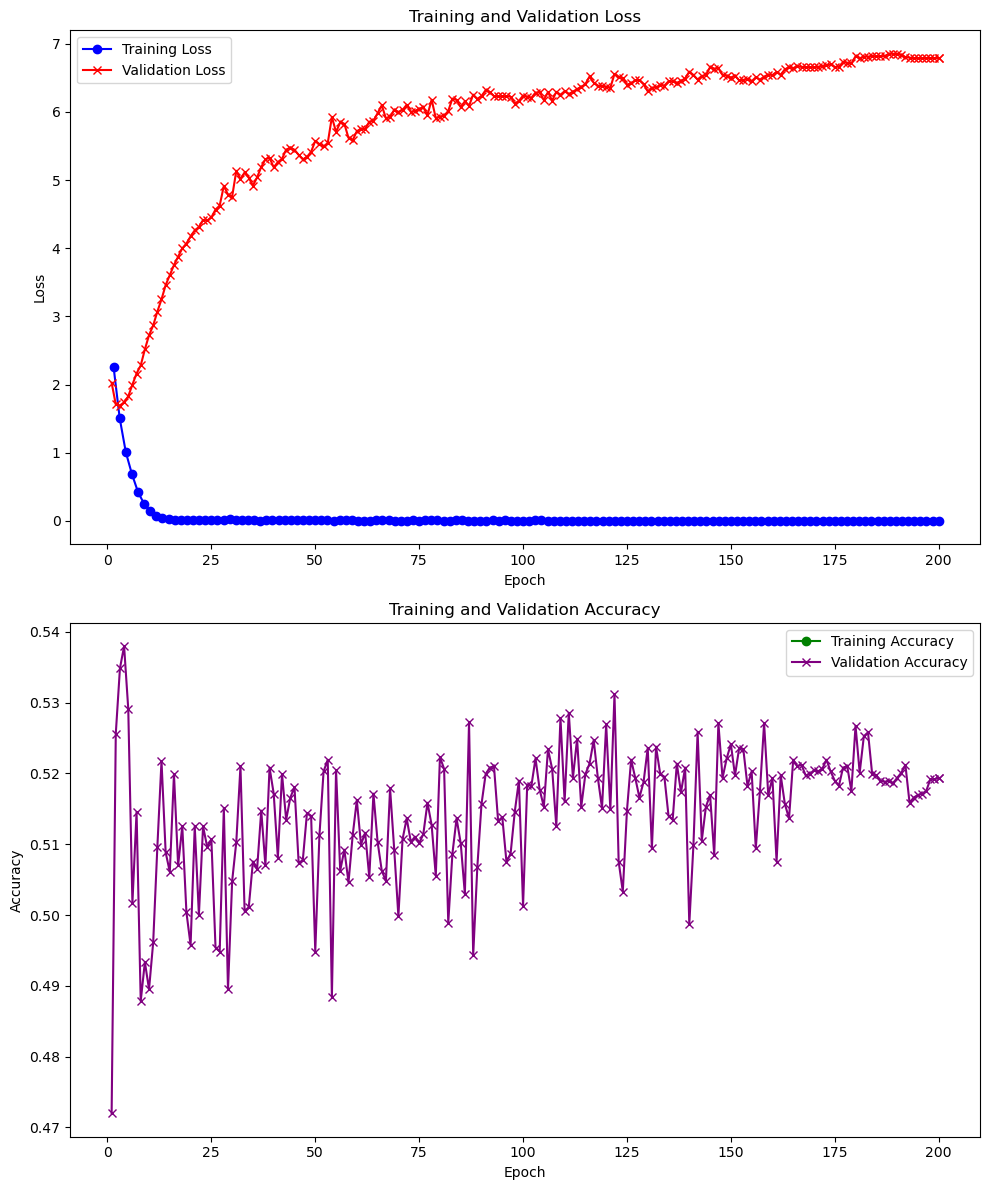

In [16]:
import json
import matplotlib.pyplot as plt

# Load logs from the file
with open("./logs/log_history.json", "r") as f:
    logs = json.load(f)

# Lists to store metrics
epochs = []
train_loss = []
eval_loss = []
train_accuracy = []
eval_accuracy = []

# Extracting relevant metrics from the logs
for log in logs:
    epoch = log.get("epoch")
    if epoch is not None:
        epochs.append(epoch)
        
        # Check if training loss is available
        if log.get("train_loss") is not None:
            train_loss.append((epoch, log["train_loss"]))
        
        # Check if validation loss is available
        if log.get("eval_loss") is not None:
            eval_loss.append((epoch, log["eval_loss"]))
        
        # Check if training accuracy is available
        if log.get("train_accuracy") is not None:
            train_accuracy.append((epoch, log["train_accuracy"]))
        
        # Check if validation accuracy is available
        if log.get("eval_accuracy") is not None:
            eval_accuracy.append((epoch, log["eval_accuracy"]))

# Sort the lists based on epochs (if they aren't already sorted)
train_loss.sort(key=lambda x: x[0])
eval_loss.sort(key=lambda x: x[0])
train_accuracy.sort(key=lambda x: x[0])
eval_accuracy.sort(key=lambda x: x[0])

# Unpack the sorted values
train_loss_epochs, train_loss_values = zip(*train_loss) if train_loss else ([], [])
eval_loss_epochs, eval_loss_values = zip(*eval_loss) if eval_loss else ([], [])
train_accuracy_epochs, train_accuracy_values = zip(*train_accuracy) if train_accuracy else ([], [])
eval_accuracy_epochs, eval_accuracy_values = zip(*eval_accuracy) if eval_accuracy else ([], [])

# Plotting Training and Evaluation Loss and Accuracy
fig, axes = plt.subplots(2, 1, figsize=(10, 12))

# Training vs Validation Loss
axes[0].plot(train_loss_epochs, train_loss_values, label="Training Loss", color="blue", marker="o")
axes[0].plot(eval_loss_epochs, eval_loss_values, label="Validation Loss", color="red", marker="x")
axes[0].set_title("Training and Validation Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()

# Training vs Validation Accuracy
axes[1].plot(train_accuracy_epochs, train_accuracy_values, label="Training Accuracy", color="green", marker="o")
axes[1].plot(eval_accuracy_epochs, eval_accuracy_values, label="Validation Accuracy", color="purple", marker="x")
axes[1].set_title("Training and Validation Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()

# Show the plots
plt.tight_layout()
plt.show()


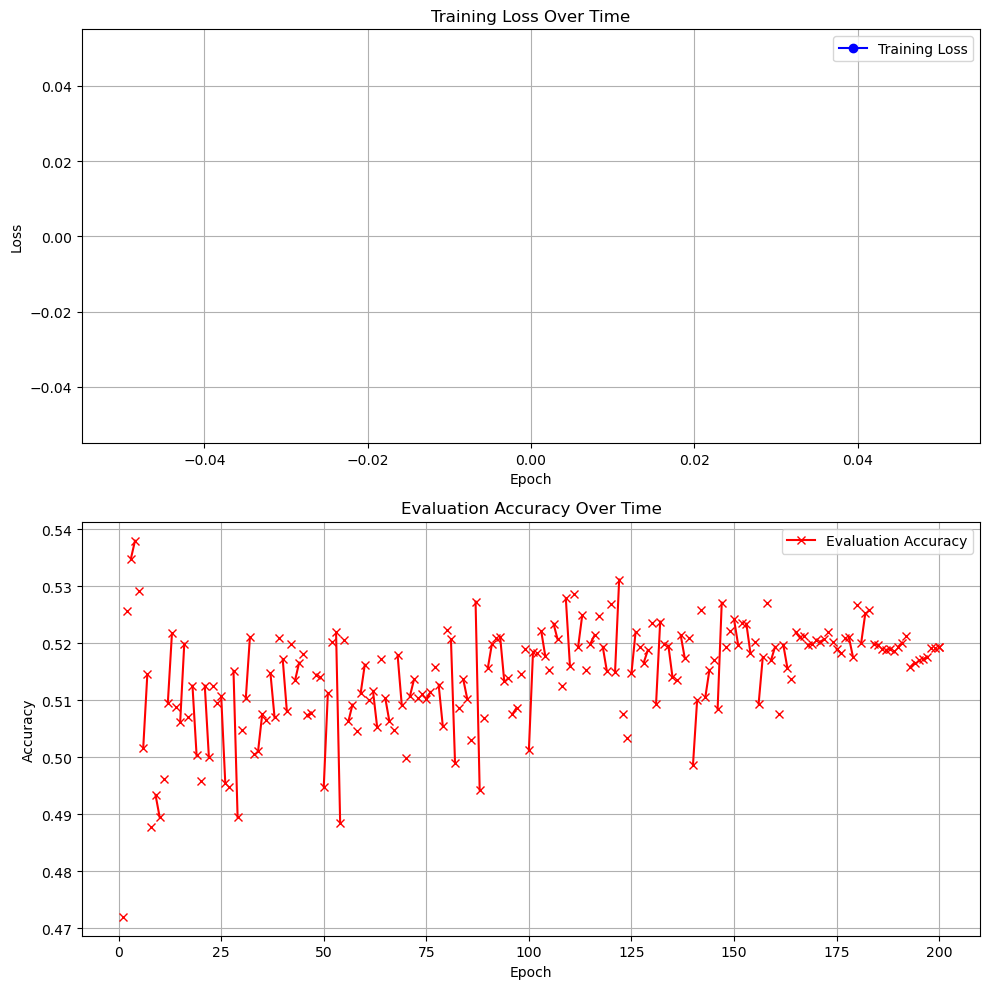

In [17]:
import json
import matplotlib.pyplot as plt

# Load logs from file
logs = []
with open("./logs/log_history.json", "r") as f:  # Adjust path as needed
    logs = json.load(f)

# Initialize lists to store data for plotting
train_epochs = []
train_loss = []
eval_epochs = []
eval_accuracy = []

# Extract data for plotting
for log in logs:
    # Extract training loss and epochs
    if "loss" in log:
        train_epochs.append(log["epoch"])
        train_loss.append(log["loss"])
    
    # Extract evaluation accuracy and epochs
    if "eval_accuracy" in log:
        eval_epochs.append(log["epoch"])
        eval_accuracy.append(log["eval_accuracy"])

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Plot Training Loss over Time
ax1.plot(train_epochs, train_loss, label="Training Loss", color='blue', marker='o')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Training Loss Over Time")
ax1.legend()
ax1.grid(True)

# Plot Evaluation Accuracy over Time
ax2.plot(eval_epochs, eval_accuracy, label="Evaluation Accuracy", color='red', marker='x')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.set_title("Evaluation Accuracy Over Time")
ax2.legend()
ax2.grid(True)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()


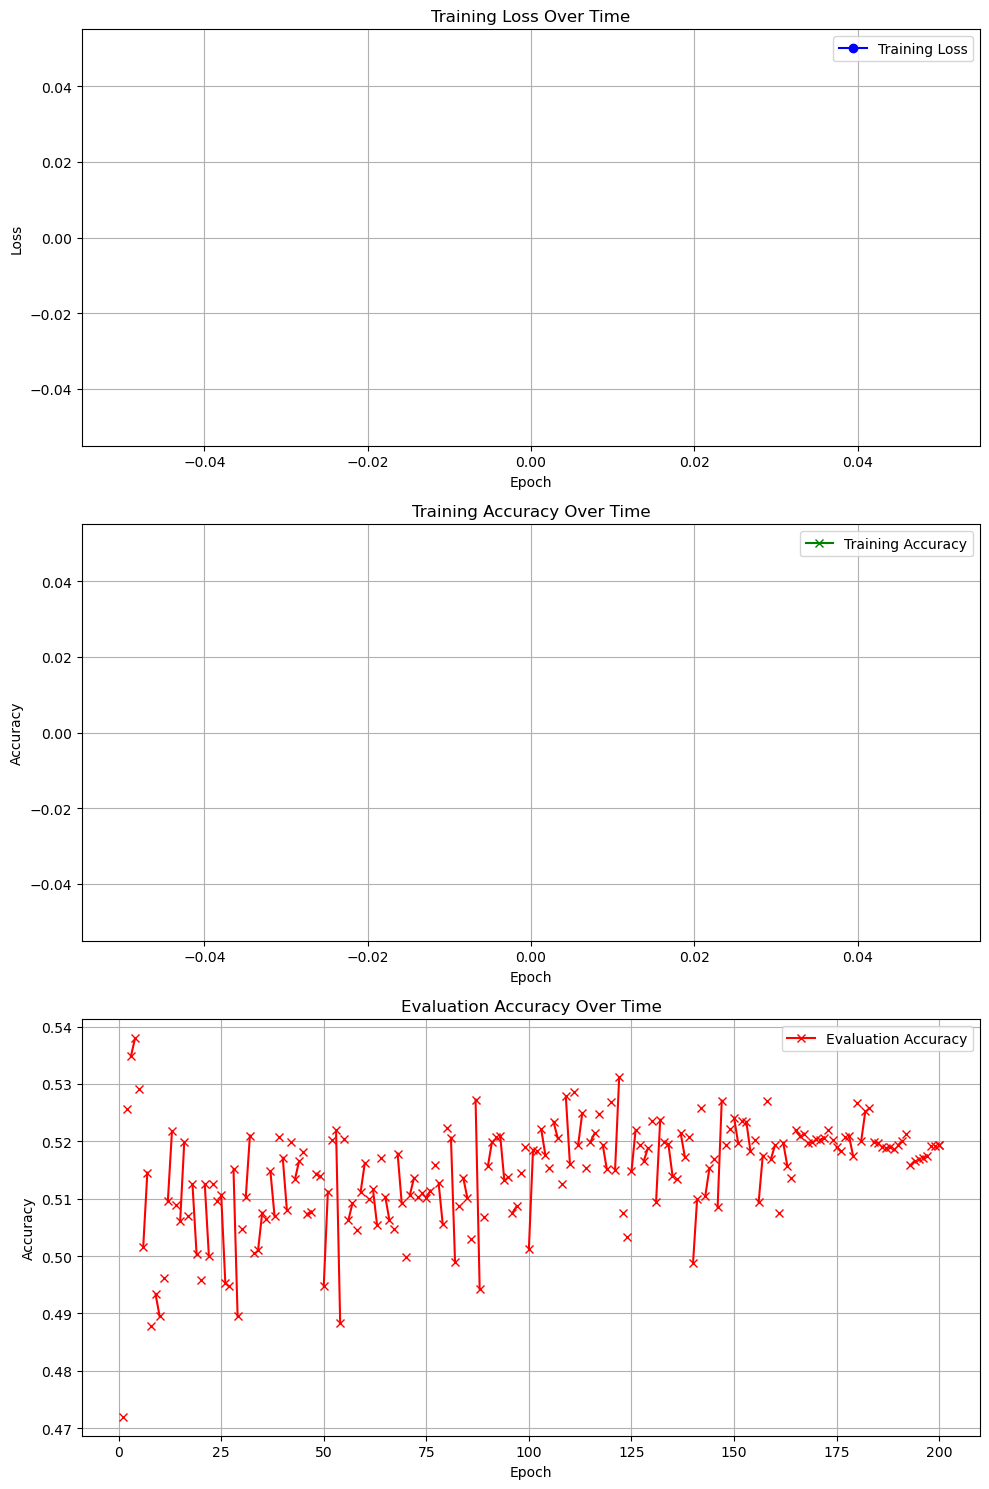

In [18]:
import json
import matplotlib.pyplot as plt

# Load logs from file
logs = []
with open("./logs/log_history.json", "r") as f:  # Adjust path as needed
    logs = json.load(f)

# Initialize lists to store data for plotting
train_epochs = []
train_loss = []
train_accuracy = []
eval_epochs = []
eval_accuracy = []

# Extract data for plotting
for log in logs:
    # Extract training loss, accuracy, and epochs
    if "loss" in log:
        train_epochs.append(log["epoch"])
        train_loss.append(log["loss"])
    if "accuracy" in log:
        train_accuracy.append(log["accuracy"])
    
    # Extract evaluation accuracy and epochs
    if "eval_accuracy" in log:
        eval_epochs.append(log["epoch"])
        eval_accuracy.append(log["eval_accuracy"])

# Create a figure with multiple subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Plot Training Loss over Time
axes[0].plot(train_epochs, train_loss, label="Training Loss", color='blue', marker='o')
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Training Loss Over Time")
axes[0].legend()
axes[0].grid(True)

# Plot Training Accuracy over Time
axes[1].plot(train_epochs, train_accuracy, label="Training Accuracy", color='green', marker='x')
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Training Accuracy Over Time")
axes[1].legend()
axes[1].grid(True)

# Plot Evaluation Accuracy over Time
axes[2].plot(eval_epochs, eval_accuracy, label="Evaluation Accuracy", color='red', marker='x')
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Accuracy")
axes[2].set_title("Evaluation Accuracy Over Time")
axes[2].legend()
axes[2].grid(True)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()


In [19]:




# Plot results
print("Plotting results...")
def plot_results(results):
    plt.figure(figsize=(10, 6))
    for model_name, res in results.items():
        accuracies = [res['standard']['accuracy'], res['qlora']['accuracy']]
        plt.plot(['Standard', 'QLoRA'], accuracies, label=model_name)
    
    plt.title('Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.xlabel('Fine-tuning Method')
    plt.legend()
    plt.grid()
    plt.show()

plot_results(results)

# Confusion matrix (example for GPT-2 standard fine-tuning)
print("Computing confusion matrix for GPT-2 (standard fine-tuning)...")
y_true = dataset['validation']['labels']
y_pred = trainer.predict(dataset['validation']).predictions
y_pred = np.argmax(y_pred, axis=-1)

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix for GPT-2 Standard Fine-tuning")
plt.ylabel("True Labels")
plt.xlabel("Predicted Labels")
plt.show()


Plotting results...


KeyError: 'accuracy'

<Figure size 1000x600 with 0 Axes>